# Ch5 | GPT 组装：从概率预测到文本生成

---

**目标：** 从零构建一个完整的 GPT 模型

**核心问题：** 如何让模型生成文本？

---

## 本章内容

1. **位置编码 (Positional Encoding)**：注入位置信息
2. **RoPE (旋转位置编码)**：现代 LLM 的标配
3. **GPT 架构**：完整模型组装
4. **文本生成**：Temperature, Top-k, Top-p 采样

---

## 前置知识：从积木到完整建筑

### 我们已经学到了什么？

前面几章我们学习了构建 LLM 的"积木"：

| 章节 | 内容 | 作用 |
|:---|:---|:---|
| Ch1 | Autograd | 自动计算梯度 |
| Ch2 | Embedding | 把词变成向量 |
| Ch3 | Self-Attention | 让词"看到"上下文 |
| Ch4 | Transformer Block | 完整的处理单元 |

### 现在：组装 GPT！

GPT (Generative Pre-trained Transformer) 的结构：

```
输入文本
   ↓
Token Embedding (Ch2) + Position Embedding
   ↓
N × Transformer Block (Ch4)
   ↓
Language Model Head (预测下一个词)
   ↓
输出概率分布
```

### 什么是位置编码？

Self-Attention 是**无序的**——它只看词之间的关系，不知道词的顺序！

```
"狗咬人" 和 "人咬狗" 对 Attention 来说一样！
```

**解决方案**：给每个位置一个独特的编码，加到词向量上

```
词向量 + 位置向量 = 带位置信息的向量
```

### 什么是 Language Model Head？

把 Transformer 的输出变成**下一个词的概率分布**：

```
隐藏状态 [batch, seq, hidden] 
    ↓ Linear层
Logits [batch, seq, vocab_size]
    ↓ Softmax
概率分布 (哪个词最可能是下一个？)
```

### 本章目标

- 实现位置编码（Sinusoidal 和 RoPE）
- 组装完整的 GPT 模型
- 理解文本生成的采样策略（Temperature, Top-k, Top-p）


## 0. 环境准备

In [1]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import numpy as np
import matplotlib.pyplot as plt

torch.manual_seed(42)
print(f"PyTorch version: {torch.__version__}")

PyTorch version: 2.8.0+cu128


C:\Users\lvbab\AppData\Local\Temp\ipykernel_96576\2567690443.py:123: UserWarning: Glyph 127959 (\N{BUILDING CONSTRUCTION}) missing from font(s) DejaVu Sans.
  plt.tight_layout()
C:\Users\lvbab\AppData\Local\Temp\ipykernel_96576\2567690443.py:123: UserWarning: Glyph 128260 (\N{ANTICLOCKWISE DOWNWARDS AND UPWARDS OPEN CIRCLE ARROWS}) missing from font(s) DejaVu Sans.
  plt.tight_layout()


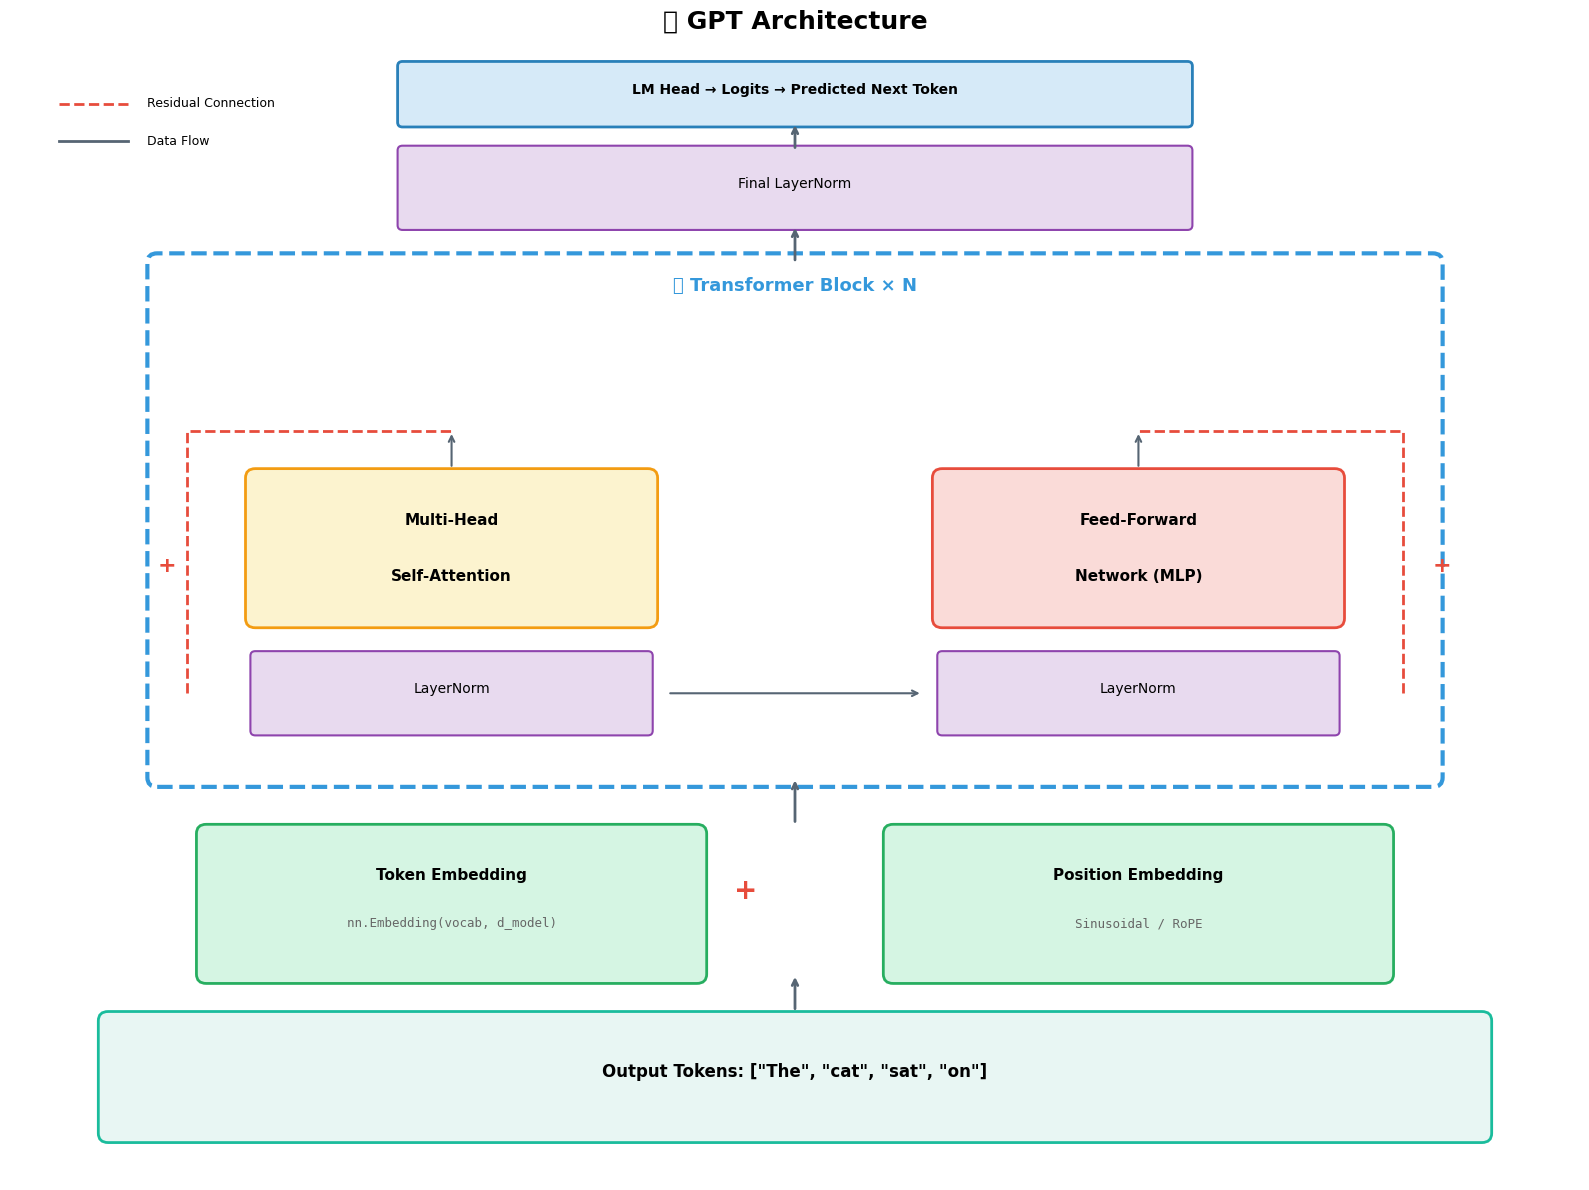


📐 GPT 关键组件：
   1. Token + Position Embedding → 注入位置信息
   2. N × Transformer Block → 提取语义特征
   3. 每个Block: LayerNorm → Attention → 残差 → LayerNorm → FFN → 残差
   4. LM Head → 预测词表中每个词的概率


In [ ]:
# 🎨 GPT 架构全景图
import matplotlib.pyplot as plt
import matplotlib.patches as patches
from matplotlib.patches import FancyBboxPatch, FancyArrowPatch
import numpy as np
import os
from matplotlib import font_manager as fm
import matplotlib as mpl
font_path = "../assets/fonts/NotoSansCJKsc-Regular.otf"
if os.path.exists(font_path):
    fm.fontManager.addfont(font_path)

mpl.rcParams["font.family"] = "sans-serif"
mpl.rcParams["font.sans-serif"] = ["Noto Sans CJK SC", "DejaVu Sans"]
mpl.rcParams["axes.unicode_minus"] = False

def draw_gpt_architecture():
    """
    绘制 GPT 架构的完整示意图
    展示从输入到输出的完整数据流
    """
    fig, ax = plt.subplots(figsize=(16, 12))
    ax.set_xlim(0, 16)
    ax.set_ylim(0, 12)
    ax.axis('off')
    ax.set_title('GPT Architecture', fontsize=18, fontweight='bold', pad=20)
    
    # 颜色定义
    colors = {
        'input': '#E8F6F3',
        'embedding': '#D5F5E3',
        'attention': '#FCF3CF',
        'ffn': '#FADBD8',
        'norm': '#E8DAEF',
        'output': '#D6EAF8',
        'arrow': '#566573'
    }
    
    # ===== 输入层 =====
    ax.add_patch(FancyBboxPatch((1, 0.5), 14, 1.2, boxstyle='round,pad=0.1',
                                facecolor=colors['input'], edgecolor='#1ABC9C', linewidth=2))
    ax.text(8, 1.1, 'Output Tokens: ["The", "cat", "sat", "on"]', fontsize=12, ha='center', fontweight='bold')
    
    # 箭头
    ax.annotate('', xy=(8, 2.2), xytext=(8, 1.8),
               arrowprops=dict(arrowstyle='->', color=colors['arrow'], lw=2))
    
    # ===== Embedding 层 =====
    ax.add_patch(FancyBboxPatch((2, 2.2), 5, 1.5, boxstyle='round,pad=0.1',
                                facecolor=colors['embedding'], edgecolor='#27AE60', linewidth=2))
    ax.text(4.5, 3.2, 'Token Embedding', fontsize=11, ha='center', fontweight='bold')
    ax.text(4.5, 2.7, 'nn.Embedding(vocab, d_model)', fontsize=9, ha='center', family='monospace', color='#666')
    
    ax.add_patch(FancyBboxPatch((9, 2.2), 5, 1.5, boxstyle='round,pad=0.1',
                                facecolor=colors['embedding'], edgecolor='#27AE60', linewidth=2))
    ax.text(11.5, 3.2, 'Position Embedding', fontsize=11, ha='center', fontweight='bold')
    ax.text(11.5, 2.7, 'Sinusoidal / RoPE', fontsize=9, ha='center', family='monospace', color='#666')
    
    # + 号
    ax.text(7.5, 3, '+', fontsize=20, ha='center', fontweight='bold', color='#E74C3C')
    
    ax.annotate('', xy=(8, 4.3), xytext=(8, 3.8),
               arrowprops=dict(arrowstyle='->', color=colors['arrow'], lw=2))
    
    # ===== Transformer Block (展开一个) =====
    # 外框
    ax.add_patch(FancyBboxPatch((1.5, 4.3), 13, 5.5, boxstyle='round,pad=0.1',
                                facecolor='white', edgecolor='#3498DB', linewidth=3, linestyle='--'))
    ax.text(8, 9.5, 'Transformer Block × N', fontsize=13, ha='center', fontweight='bold', color='#3498DB')
    
    # LayerNorm 1
    ax.add_patch(FancyBboxPatch((2.5, 4.8), 4, 0.8, boxstyle='round,pad=0.05',
                                facecolor=colors['norm'], edgecolor='#8E44AD', linewidth=1.5))
    ax.text(4.5, 5.2, 'LayerNorm', fontsize=10, ha='center')
    
    # Multi-Head Attention
    ax.add_patch(FancyBboxPatch((2.5, 6), 4, 1.5, boxstyle='round,pad=0.1',
                                facecolor=colors['attention'], edgecolor='#F39C12', linewidth=2))
    ax.text(4.5, 7, 'Multi-Head', fontsize=11, ha='center', fontweight='bold')
    ax.text(4.5, 6.4, 'Self-Attention', fontsize=11, ha='center', fontweight='bold')
    
    # 残差连接 1
    ax.annotate('', xy=(4.5, 8), xytext=(4.5, 7.6),
               arrowprops=dict(arrowstyle='->', color=colors['arrow'], lw=1.5))
    ax.plot([1.8, 1.8, 4.5], [5.2, 8, 8], color='#E74C3C', linewidth=2, linestyle='--')
    ax.text(1.5, 6.5, '+', fontsize=16, color='#E74C3C', fontweight='bold')
    
    # LayerNorm 2
    ax.add_patch(FancyBboxPatch((9.5, 4.8), 4, 0.8, boxstyle='round,pad=0.05',
                                facecolor=colors['norm'], edgecolor='#8E44AD', linewidth=1.5))
    ax.text(11.5, 5.2, 'LayerNorm', fontsize=10, ha='center')
    
    # FFN
    ax.add_patch(FancyBboxPatch((9.5, 6), 4, 1.5, boxstyle='round,pad=0.1',
                                facecolor=colors['ffn'], edgecolor='#E74C3C', linewidth=2))
    ax.text(11.5, 7, 'Feed-Forward', fontsize=11, ha='center', fontweight='bold')
    ax.text(11.5, 6.4, 'Network (MLP)', fontsize=11, ha='center', fontweight='bold')
    
    # 残差连接 2
    ax.annotate('', xy=(11.5, 8), xytext=(11.5, 7.6),
               arrowprops=dict(arrowstyle='->', color=colors['arrow'], lw=1.5))
    ax.plot([14.2, 14.2, 11.5], [5.2, 8, 8], color='#E74C3C', linewidth=2, linestyle='--')
    ax.text(14.5, 6.5, '+', fontsize=16, color='#E74C3C', fontweight='bold')
    
    # 连接两部分
    ax.annotate('', xy=(9.3, 5.2), xytext=(6.7, 5.2),
               arrowprops=dict(arrowstyle='->', color=colors['arrow'], lw=1.5))
    
    # ===== 输出层 =====
    ax.annotate('', xy=(8, 10.2), xytext=(8, 9.8),
               arrowprops=dict(arrowstyle='->', color=colors['arrow'], lw=2))
    
    ax.add_patch(FancyBboxPatch((4, 10.2), 8, 0.8, boxstyle='round,pad=0.05',
                                facecolor=colors['norm'], edgecolor='#8E44AD', linewidth=1.5))
    ax.text(8, 10.6, 'Final LayerNorm', fontsize=10, ha='center')
    
    ax.annotate('', xy=(8, 11.3), xytext=(8, 11),
               arrowprops=dict(arrowstyle='->', color=colors['arrow'], lw=2))
    
    ax.add_patch(FancyBboxPatch((4, 11.3), 8, 0.6, boxstyle='round,pad=0.05',
                                facecolor=colors['output'], edgecolor='#2980B9', linewidth=2))
    ax.text(8, 11.6, 'LM Head → Logits → Predicted Next Token', fontsize=10, ha='center', fontweight='bold')
    
    # ===== 图例 =====
    legend_items = [
        ('Residual Connection', '#E74C3C', '--'),
        ('Data Flow', '#566573', '-'),
    ]
    for i, (label, color, style) in enumerate(legend_items):
        ax.plot([0.5, 1.2], [11.5 - i*0.4, 11.5 - i*0.4], color=color, linewidth=2, linestyle=style)
        ax.text(1.4, 11.5 - i*0.4, label, fontsize=9, va='center')
    
    plt.tight_layout()
    plt.show()
    
    print("\n📐 GPT 关键组件：")
    print("   1. Token + Position Embedding → 注入位置信息")
    print("   2. N × Transformer Block → 提取语义特征")
    print("   3. 每个Block: LayerNorm → Attention → 残差 → LayerNorm → FFN → 残差")
    print("   4. LM Head → 预测词表中每个词的概率")

draw_gpt_architecture()

---

## 1. 位置编码：告诉模型"这是第几个词"

### 为什么需要位置编码？

Attention 机制是**无序的**！它只看词之间的相似度，不知道词的顺序。

但语言是有顺序的："狗咬人" ≠ "人咬狗"

### 解决方案

给每个位置一个独特的向量，加到 word embedding 上。

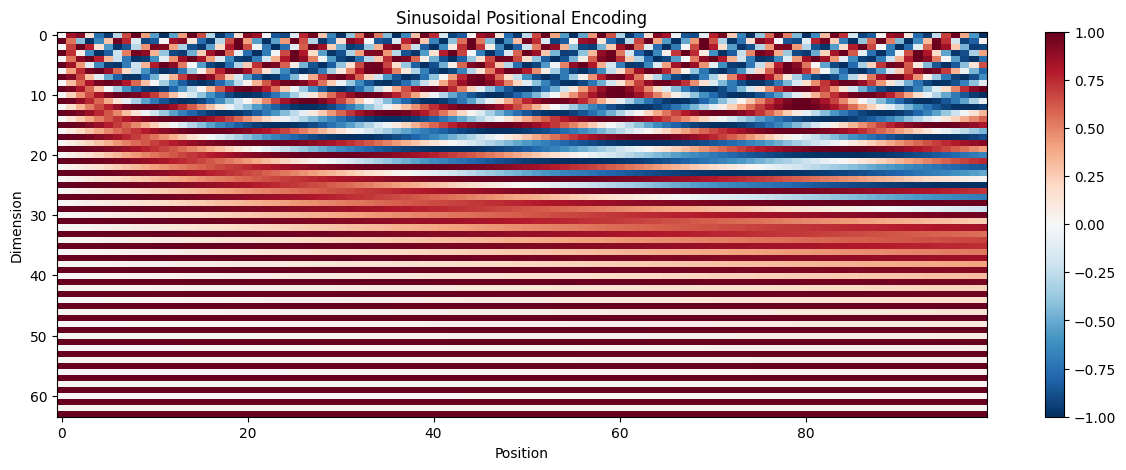

每个位置有唯一的编码模式！


In [8]:
class SinusoidalPositionalEncoding(nn.Module):
    """
    正弦位置编码（Transformer 原论文）
    
    PE(pos, 2i)   = sin(pos / 10000^(2i/d_model))
    PE(pos, 2i+1) = cos(pos / 10000^(2i/d_model))
    """
    def __init__(self, d_model, max_len=5000):
        super().__init__()
        
        # 创建位置编码矩阵
        pe = torch.zeros(max_len, d_model)
        position = torch.arange(0, max_len, dtype=torch.float).unsqueeze(1)
        div_term = torch.exp(torch.arange(0, d_model, 2).float() * (-np.log(10000.0) / d_model))
        
        pe[:, 0::2] = torch.sin(position * div_term)  # 偶数维度
        pe[:, 1::2] = torch.cos(position * div_term)  # 奇数维度
        
        pe = pe.unsqueeze(0)  # [1, max_len, d_model]
        self.register_buffer('pe', pe)
    
    def forward(self, x):
        # x: [batch, seq_len, d_model]
        return x + self.pe[:, :x.size(1), :]

# 可视化位置编码
pos_enc = SinusoidalPositionalEncoding(d_model=64)
pe = pos_enc.pe[0, :100, :].numpy()

plt.figure(figsize=(15, 5))
plt.imshow(pe.T, aspect='auto', cmap='RdBu_r')
plt.colorbar()
plt.xlabel('Position')
plt.ylabel('Dimension')
plt.title('Sinusoidal Positional Encoding')
plt.show()

print("每个位置有唯一的编码模式！")

---

## 2. RoPE：旋转位置编码

现代 LLM（LLaMA, Mistral）都用 RoPE，优点：
- 可以外推到更长的序列
- 相对位置信息更自然

In [9]:
def precompute_freqs_cis(dim, max_seq_len, theta=10000.0):
    """预计算 RoPE 的频率"""
    freqs = 1.0 / (theta ** (torch.arange(0, dim, 2).float() / dim))
    t = torch.arange(max_seq_len)
    freqs = torch.outer(t, freqs)
    freqs_cis = torch.polar(torch.ones_like(freqs), freqs)  # e^(i*theta)
    return freqs_cis

def apply_rotary_emb(xq, xk, freqs_cis):
    """应用旋转位置编码"""
    # 将 real tensor 转换为 complex
    xq_ = torch.view_as_complex(xq.float().reshape(*xq.shape[:-1], -1, 2))
    xk_ = torch.view_as_complex(xk.float().reshape(*xk.shape[:-1], -1, 2))
    
    # 旋转
    freqs_cis = freqs_cis.unsqueeze(0).unsqueeze(2)  # [1, seq, 1, dim/2]
    xq_out = torch.view_as_real(xq_ * freqs_cis).flatten(-2)
    xk_out = torch.view_as_real(xk_ * freqs_cis).flatten(-2)
    
    return xq_out.type_as(xq), xk_out.type_as(xk)

# 测试
dim = 64
max_seq_len = 100
freqs_cis = precompute_freqs_cis(dim, max_seq_len)

print(f"频率形状: {freqs_cis.shape}")
print("RoPE 本质是在复数空间中旋转向量！")

频率形状: torch.Size([100, 32])
RoPE 本质是在复数空间中旋转向量！


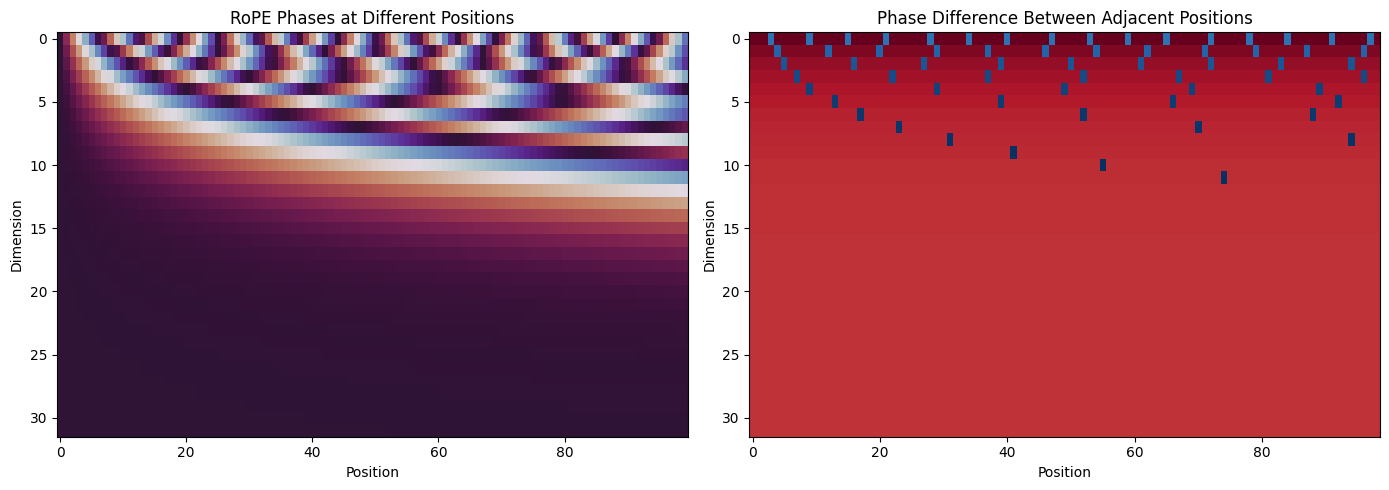

In [10]:
# 可视化 RoPE
fig, axes = plt.subplots(1, 2, figsize=(14, 5))

# 不同位置的相位
phases = torch.angle(freqs_cis).numpy()
axes[0].imshow(phases.T, aspect='auto', cmap='twilight')
axes[0].set_xlabel('Position')
axes[0].set_ylabel('Dimension')
axes[0].set_title('RoPE Phases at Different Positions')

# 相邻位置的差异
pos_diff = phases[1:] - phases[:-1]
axes[1].imshow(pos_diff.T, aspect='auto', cmap='RdBu_r')
axes[1].set_xlabel('Position')
axes[1].set_ylabel('Dimension')
axes[1].set_title('Phase Difference Between Adjacent Positions')

plt.tight_layout()
plt.show()

---

## 3. 完整 GPT 模型

In [11]:
class CausalSelfAttention(nn.Module):
    """带有 causal mask 的自注意力"""
    def __init__(self, config):
        super().__init__()
        assert config['n_embd'] % config['n_head'] == 0
        
        self.n_head = config['n_head']
        self.n_embd = config['n_embd']
        self.head_dim = config['n_embd'] // config['n_head']
        
        self.c_attn = nn.Linear(config['n_embd'], 3 * config['n_embd'])
        self.c_proj = nn.Linear(config['n_embd'], config['n_embd'])
        self.dropout = nn.Dropout(config['dropout'])
        
        # Causal mask
        self.register_buffer("mask", torch.tril(
            torch.ones(config['block_size'], config['block_size'])
        ).view(1, 1, config['block_size'], config['block_size']))
    
    def forward(self, x):
        B, T, C = x.size()
        
        # Q, K, V
        q, k, v = self.c_attn(x).split(self.n_embd, dim=2)
        q = q.view(B, T, self.n_head, self.head_dim).transpose(1, 2)
        k = k.view(B, T, self.n_head, self.head_dim).transpose(1, 2)
        v = v.view(B, T, self.n_head, self.head_dim).transpose(1, 2)
        
        # Attention
        att = (q @ k.transpose(-2, -1)) / np.sqrt(self.head_dim)
        att = att.masked_fill(self.mask[:, :, :T, :T] == 0, float('-inf'))
        att = F.softmax(att, dim=-1)
        att = self.dropout(att)
        
        y = att @ v
        y = y.transpose(1, 2).contiguous().view(B, T, C)
        return self.c_proj(y)

class MLP(nn.Module):
    def __init__(self, config):
        super().__init__()
        self.c_fc = nn.Linear(config['n_embd'], 4 * config['n_embd'])
        self.c_proj = nn.Linear(4 * config['n_embd'], config['n_embd'])
        self.dropout = nn.Dropout(config['dropout'])
    
    def forward(self, x):
        x = F.gelu(self.c_fc(x))
        x = self.dropout(self.c_proj(x))
        return x

class Block(nn.Module):
    def __init__(self, config):
        super().__init__()
        self.ln_1 = nn.LayerNorm(config['n_embd'])
        self.attn = CausalSelfAttention(config)
        self.ln_2 = nn.LayerNorm(config['n_embd'])
        self.mlp = MLP(config)
    
    def forward(self, x):
        x = x + self.attn(self.ln_1(x))
        x = x + self.mlp(self.ln_2(x))
        return x

In [12]:
class GPT(nn.Module):
    """
    GPT 语言模型
    """
    def __init__(self, config):
        super().__init__()
        self.config = config
        
        self.transformer = nn.ModuleDict(dict(
            wte = nn.Embedding(config['vocab_size'], config['n_embd']),  # token embedding
            wpe = nn.Embedding(config['block_size'], config['n_embd']), # position embedding
            drop = nn.Dropout(config['dropout']),
            h = nn.ModuleList([Block(config) for _ in range(config['n_layer'])]),
            ln_f = nn.LayerNorm(config['n_embd']),
        ))
        self.lm_head = nn.Linear(config['n_embd'], config['vocab_size'], bias=False)
        
        # 权重共享（减少参数）
        self.transformer.wte.weight = self.lm_head.weight
        
        # 初始化
        self.apply(self._init_weights)
        print(f"GPT 参数量: {self.get_num_params():,}")
    
    def _init_weights(self, module):
        if isinstance(module, nn.Linear):
            torch.nn.init.normal_(module.weight, mean=0.0, std=0.02)
            if module.bias is not None:
                torch.nn.init.zeros_(module.bias)
        elif isinstance(module, nn.Embedding):
            torch.nn.init.normal_(module.weight, mean=0.0, std=0.02)
    
    def get_num_params(self):
        return sum(p.numel() for p in self.parameters())
    
    def forward(self, idx, targets=None):
        B, T = idx.size()
        assert T <= self.config['block_size']
        
        # Embeddings
        pos = torch.arange(0, T, dtype=torch.long, device=idx.device)
        tok_emb = self.transformer.wte(idx)  # [B, T, n_embd]
        pos_emb = self.transformer.wpe(pos)  # [T, n_embd]
        x = self.transformer.drop(tok_emb + pos_emb)
        
        # Transformer blocks
        for block in self.transformer.h:
            x = block(x)
        x = self.transformer.ln_f(x)
        
        # 输出 logits
        logits = self.lm_head(x)  # [B, T, vocab_size]
        
        # 计算 loss（如果有目标）
        loss = None
        if targets is not None:
            loss = F.cross_entropy(logits.view(-1, logits.size(-1)), targets.view(-1))
        
        return logits, loss

# 创建一个小型 GPT
config = {
    'vocab_size': 1000,
    'block_size': 128,   # 最大序列长度
    'n_layer': 4,        # Transformer 层数
    'n_head': 4,         # 注意力头数
    'n_embd': 128,       # 嵌入维度
    'dropout': 0.1,
}

model = GPT(config)

GPT 参数量: 937,728


---

## 4. 文本生成：采样策略

有了模型后，如何生成文本？

关键在于**如何从概率分布中采样**。

In [13]:
@torch.no_grad()
def generate(model, idx, max_new_tokens, temperature=1.0, top_k=None, top_p=None):
    """
    自回归生成
    
    idx: [B, T] 初始 token 序列
    temperature: 控制随机性（越大越随机）
    top_k: 只从概率最高的 k 个中采样
    top_p: 只从累积概率达到 p 的 token 中采样
    """
    model.eval()
    
    for _ in range(max_new_tokens):
        # 截断到最大长度
        idx_cond = idx if idx.size(1) <= model.config['block_size'] else idx[:, -model.config['block_size']:]
        
        # 前向传播得到 logits
        logits, _ = model(idx_cond)
        logits = logits[:, -1, :]  # 只取最后一个位置 [B, vocab_size]
        
        # Temperature scaling
        logits = logits / temperature
        
        # Top-k 过滤
        if top_k is not None:
            v, _ = torch.topk(logits, min(top_k, logits.size(-1)))
            logits[logits < v[:, [-1]]] = float('-inf')
        
        # Top-p (nucleus) 过滤
        if top_p is not None:
            sorted_logits, sorted_indices = torch.sort(logits, descending=True)
            cumulative_probs = torch.cumsum(F.softmax(sorted_logits, dim=-1), dim=-1)
            
            # 移除累积概率超过 top_p 的 token
            sorted_indices_to_remove = cumulative_probs > top_p
            sorted_indices_to_remove[..., 1:] = sorted_indices_to_remove[..., :-1].clone()
            sorted_indices_to_remove[..., 0] = 0
            
            indices_to_remove = sorted_indices_to_remove.scatter(1, sorted_indices, sorted_indices_to_remove)
            logits[indices_to_remove] = float('-inf')
        
        # 采样
        probs = F.softmax(logits, dim=-1)
        idx_next = torch.multinomial(probs, num_samples=1)
        
        # 拼接
        idx = torch.cat((idx, idx_next), dim=1)
    
    return idx

print("生成函数定义完成！")

生成函数定义完成！


C:\Users\lvbab\AppData\Local\Temp\ipykernel_96576\4168462409.py:16: UserWarning: Glyph 23545 (\N{CJK UNIFIED IDEOGRAPH-5BF9}) missing from font(s) DejaVu Sans.
  plt.tight_layout()
C:\Users\lvbab\AppData\Local\Temp\ipykernel_96576\4168462409.py:16: UserWarning: Glyph 27010 (\N{CJK UNIFIED IDEOGRAPH-6982}) missing from font(s) DejaVu Sans.
  plt.tight_layout()
C:\Users\lvbab\AppData\Local\Temp\ipykernel_96576\4168462409.py:16: UserWarning: Glyph 29575 (\N{CJK UNIFIED IDEOGRAPH-7387}) missing from font(s) DejaVu Sans.
  plt.tight_layout()
C:\Users\lvbab\AppData\Local\Temp\ipykernel_96576\4168462409.py:16: UserWarning: Glyph 20998 (\N{CJK UNIFIED IDEOGRAPH-5206}) missing from font(s) DejaVu Sans.
  plt.tight_layout()
C:\Users\lvbab\AppData\Local\Temp\ipykernel_96576\4168462409.py:16: UserWarning: Glyph 24067 (\N{CJK UNIFIED IDEOGRAPH-5E03}) missing from font(s) DejaVu Sans.
  plt.tight_layout()
C:\Users\lvbab\AppData\Local\Temp\ipykernel_96576\4168462409.py:16: UserWarning: Glyph 30340 (\

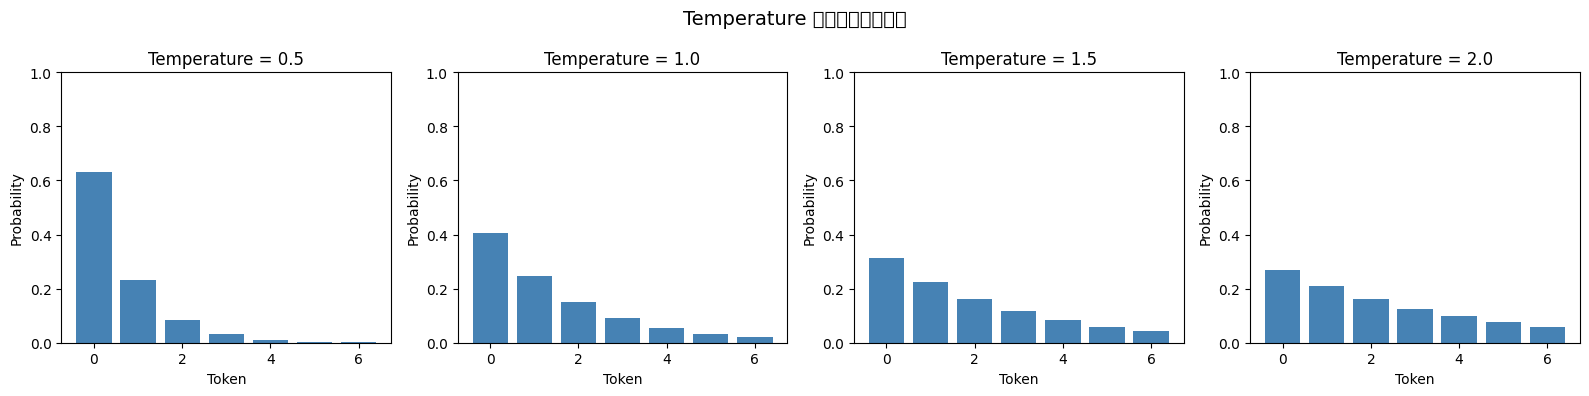

Temperature:
  低 (0.5): 更确定性，选择高概率 token
  高 (2.0): 更随机，概率分布更平坦


In [14]:
# 可视化不同 temperature 的效果
logits = torch.tensor([2.0, 1.5, 1.0, 0.5, 0.0, -0.5, -1.0])
temperatures = [0.5, 1.0, 1.5, 2.0]

fig, axes = plt.subplots(1, 4, figsize=(16, 4))

for i, temp in enumerate(temperatures):
    probs = F.softmax(logits / temp, dim=-1).numpy()
    axes[i].bar(range(len(probs)), probs, color='steelblue')
    axes[i].set_title(f'Temperature = {temp}')
    axes[i].set_xlabel('Token')
    axes[i].set_ylabel('Probability')
    axes[i].set_ylim(0, 1)

plt.suptitle('Temperature 对概率分布的影响', fontsize=14)
plt.tight_layout()
plt.show()

print("Temperature:")
print("  低 (0.5): 更确定性，选择高概率 token")
print("  高 (2.0): 更随机，概率分布更平坦")

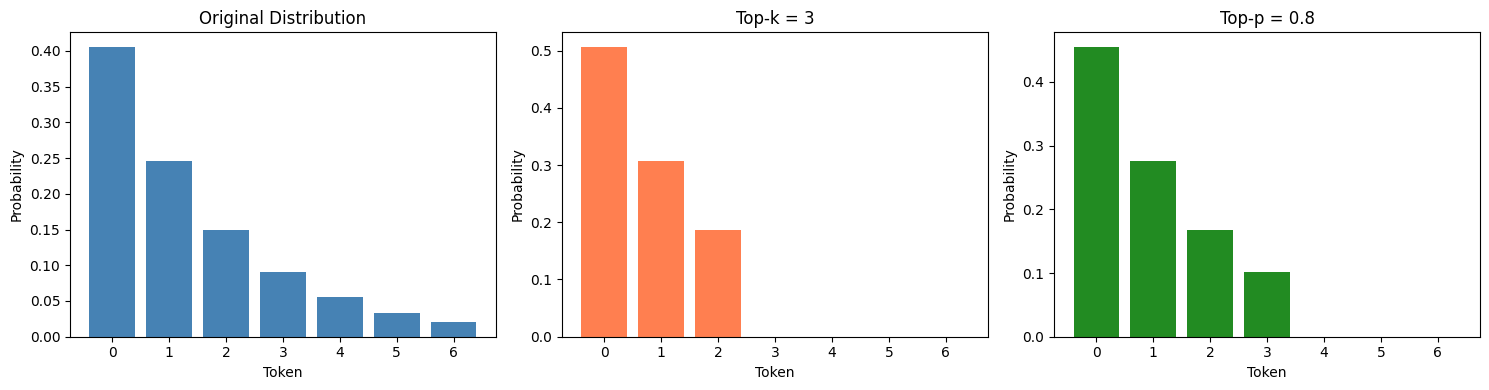

Top-k: 只保留概率最高的 k 个
Top-p: 保留累积概率达到 p 的 token


In [15]:
# 可视化 Top-k 和 Top-p
fig, axes = plt.subplots(1, 3, figsize=(15, 4))

# 原始分布
probs = F.softmax(logits, dim=-1).numpy()
axes[0].bar(range(len(probs)), probs, color='steelblue')
axes[0].set_title('Original Distribution')
axes[0].set_xlabel('Token')
axes[0].set_ylabel('Probability')

# Top-k = 3
top_k_probs = probs.copy()
top_k_probs[np.argsort(top_k_probs)[:-3]] = 0
top_k_probs = top_k_probs / top_k_probs.sum()
axes[1].bar(range(len(top_k_probs)), top_k_probs, color='coral')
axes[1].set_title('Top-k = 3')
axes[1].set_xlabel('Token')
axes[1].set_ylabel('Probability')

# Top-p = 0.8
sorted_probs = np.sort(probs)[::-1]
cumsum = np.cumsum(sorted_probs)
cutoff_idx = np.searchsorted(cumsum, 0.8) + 1
top_p_probs = probs.copy()
threshold = sorted_probs[min(cutoff_idx, len(sorted_probs)-1)]
top_p_probs[probs < threshold] = 0
top_p_probs = top_p_probs / top_p_probs.sum()
axes[2].bar(range(len(top_p_probs)), top_p_probs, color='forestgreen')
axes[2].set_title('Top-p = 0.8')
axes[2].set_xlabel('Token')
axes[2].set_ylabel('Probability')

plt.tight_layout()
plt.show()

print("Top-k: 只保留概率最高的 k 个")
print("Top-p: 保留累积概率达到 p 的 token")

In [16]:
# 测试生成（随机输入）
model.eval()
idx = torch.randint(0, config['vocab_size'], (1, 5))  # 5个初始token

print("初始序列:", idx[0].tolist())

# 不同采样策略
generated_greedy = generate(model, idx.clone(), max_new_tokens=10, temperature=0.1)
generated_random = generate(model, idx.clone(), max_new_tokens=10, temperature=1.5)
generated_topk = generate(model, idx.clone(), max_new_tokens=10, temperature=1.0, top_k=5)
generated_topp = generate(model, idx.clone(), max_new_tokens=10, temperature=1.0, top_p=0.9)

print(f"\nGreedy (temp=0.1): {generated_greedy[0].tolist()}")
print(f"Random (temp=1.5): {generated_random[0].tolist()}")
print(f"Top-k (k=5):       {generated_topk[0].tolist()}")
print(f"Top-p (p=0.9):     {generated_topp[0].tolist()}")

print("\n注意：模型未训练，生成的是随机数字")
print("训练后才能生成有意义的文本！")

初始序列: [607, 484, 901, 954, 177]

Greedy (temp=0.1): [607, 484, 901, 954, 177, 678, 200, 588, 701, 820, 476, 514, 102, 721, 637]
Random (temp=1.5): [607, 484, 901, 954, 177, 315, 821, 824, 52, 901, 467, 135, 356, 19, 622]
Top-k (k=5):       [607, 484, 901, 954, 177, 206, 772, 240, 701, 701, 476, 257, 496, 496, 496]
Top-p (p=0.9):     [607, 484, 901, 954, 177, 902, 417, 441, 235, 467, 243, 339, 77, 108, 763]

注意：模型未训练，生成的是随机数字
训练后才能生成有意义的文本！


---

## 本章总结


1. **位置编码**
   - 正弦位置编码：固定的，基于三角函数
   - RoPE：可学习的，更好的长度外推

2. **GPT 架构**
   - Token + Position Embedding
   - N 个 Transformer Block
   - LM Head 预测下一个 token

3. **采样策略**
   - Temperature：控制随机性
   - Top-k：只从 k 个最高概率中选
   - Top-p：从累积概率达到 p 的集合中选


---

## 思考

1. **增加模型规模**：尝试更多层、更大的 n_embd
2. **对比采样策略**：在同一个 prompt 上测试不同策略
3. **实现 RoPE**：把位置编码换成 RoPE

In [ ]:
# 练习空间

